# Data processing

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.functional as F
import os
import sklearn

from sklearn.model_selection import train_test_split

In [2]:
import pathlib
root_path = pathlib.Path('/content/drive/MyDrive/ITMO/IndustryML/LW2/')

In [3]:
meta_df = pd.read_csv(root_path / 'movies.csv')
meta_df.head()

,id,title,short,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Romance,Sci-Fi,Short,Sport,Superhero,Talk-Show,Thriller,War,Western,\N
0,10,Leaving the Factory,Workers leaving the Lumière factory for lunch ...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,12,The Arrival of a Train,A train arrives at La Ciotat station.,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,70,Demolition of a Wall,Auguste Lumière directs four workers in the de...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,91,The House of the Devil,"With the help of a magic cauldron, Mephistophe...",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,211,"The Astronomer's Dream; or, the Man in the Moon",An astronomer falls asleep and has a strange d...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
images_ids = {int(id.split('.')[0]): id for id in os.listdir(root_path / 'img')} # Mapping from int id to image name

In [5]:
meta_df['img_name'] = meta_df['id'].apply(lambda x: images_ids[x])

In [6]:
target_genres = [
'Action',
'Adventure',
'Animation',
'Biography',
'Comedy', 'Crime', 'Documentary', 'Drama',
'Family', 'Fantasy', 'Film-Noir', 'History',
'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
'Sci-Fi', 'Short', 'Sport', 'Superhero', 'Thriller', 'War', 'Western'
]
len(target_genres)

24

In [7]:
X, y = meta_df[['id', 'title', 'short', 'img_name']], meta_df[target_genres]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
assert not (y_train.mean() - y_test.mean() > 0.01).any() # Check difference in distribution below 1$
assert not (y_train.mean() == 0).any() # Check there is examples of each class
assert not (y_test.mean() == 0).any()

In [10]:
bce_weights = torch.tensor(1.0 / y_train.mean().values)
bce_weights

tensor([  5.5565,   8.7645,  21.2062,  23.3491,   3.5393,   6.7908,  16.0000,
          2.1282,  19.2346,  17.4090,  82.3704,  32.5861,   6.2058,  41.6674,
         55.0836,  12.1282,   7.8138,  15.4983,  24.3060,  76.6897, 117.8278,
          6.3566,  44.9293,  45.8557], dtype=torch.float64)

# Prediction

In [11]:
pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 10.7 MB/s 
     |████████████████████████████████| 529 kB 63.1 MB/s 
     |████████████████████████████████| 87 kB 8.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=27f61056808d7fb0dd2a04a4e1378b5260bad4f6fcfeca2d30ec2ec86d50d990
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [12]:
import typing
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [13]:
class FilmPreditor(pl.LightningModule):
  def __init__(self, predictor: nn.Module, criterion: nn.Module, optimizer_callback: typing.Callable):
    super().__init__()
    self.predictor = predictor
    self.criterion = criterion
    self.optimizer_callback = optimizer_callback
  
  def forward(self, x):
    probs = self.predictor(x)
    return probs
  
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('train_loss', loss)
    return loss
  
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('val_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = self.optimizer_callback(self.predictor.parameters())
    return optimizer

## Visual predictor

In [14]:
class FilmCVDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame, 
               image_folder: pathlib.Path, 
               tr: typing.Optional[typing.Callable]=None,
               is_inference: bool=False):
    self.root = image_folder
    self.df = meta_df
    self.y = target_df
    self.transform = tr
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    img_name  = self.df.iloc[idx]['img_name']
    image = torchvision.io.read_image(str(self.root / img_name), mode=torchvision.io.ImageReadMode.RGB)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_inference:
      return image

    target = torch.tensor(self.y.iloc[idx].values)
    return image, target
  
  def __len__(self):
    return len(self.df)

In [15]:
preload = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [24]:
train_dl = DataLoader(FilmCVDataset(X_train, y_train, root_path / 'img', preload), batch_size=128, shuffle=True)
test_dl = DataLoader(FilmCVDataset(X_test, y_test, root_path / 'img', preload), batch_size=64, shuffle=False)
predict_dl = DataLoader(FilmCVDataset(X_test, y_test, root_path / 'img', preload, is_inference=True), batch_size=64, shuffle=False)

In [25]:
class VisualModel(nn.Module):
  def __init__(self, n_classes=24):
    super(VisualModel, self).__init__()
    self.feature_extractor = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
    self.model = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.Linear(1000, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, n_classes),
        nn.Sigmoid(),
    )
    self.feature_extractor.requires_grad_(False)
  
  def forward(self, x):
    self.feature_extractor.eval()
    with torch.no_grad():
      x = self.feature_extractor(x)
    return self.model(x)

In [27]:
m = VisualModel()
visual_predictor = FilmPreditor(m, torch.nn.BCELoss(weight=bce_weights), lambda x: torch.optim.Adam(x, lr=0.0001))

In [29]:
trainer = pl.Trainer(max_epochs=7, limit_train_batches=10, limit_val_batches=1, accelerator='gpu')
trainer.fit(visual_predictor, train_dl, test_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | predictor | VisualModel | 22.1 M
1 | criterion | BCELoss     | 0     
------------------------------------------
262 K     Trainable params
21.8 M    Non-trainable params
22.1 M    Total params
88.240    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
!cp /content/lightning_logs/version_0/checkpoints/epoch=5-step=60.ckpt /content/drive/MyDrive/ITMO/IndustryML/LW2/cv_model_resnet34.ckpt

In [31]:
output = trainer.predict(visual_predictor, dataloaders=predict_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 1it [00:00, ?it/s]

In [32]:
output_formated = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    output_formated.append(output[i][j].numpy())

In [33]:
output_formated = np.array(output_formated)
y_target = np.array(y_target)

y_target.shape, output_formated.shape

((4448, 24), (4448, 24))

## Metrics calculation

In [38]:
from sklearn import metrics

In [35]:
def compute_metrics(y_true, y_pred):
  f1 = metrics.f1_score(y_true, y_pred, average=None)
  recall = metrics.recall_score(y_true, y_pred, average=None)
  precision = metrics.precision_score(y_true, y_pred, average=None)

  return {"f1": f1, "recall": recall, "precision": precision, "f1_macro": f1.mean(), "recall_macro": recall.mean(), "precision_macro": precision.mean()}

In [44]:
y_pred = output_formated.copy()
t = 0.20
y_pred[y_pred > t] = 1
y_pred[y_pred <= t] = 0
metrics_dict = compute_metrics(y_target, y_pred)
metrics_dict

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': array([0.23336457, 0.04955752, 0.        , 0.        , 0.44545934,
        0.11775362, 0.        , 0.6391311 , 0.        , 0.        ,
        0.        , 0.        , 0.23340627, 0.        , 0.        ,
        0.        , 0.09046455, 0.00696864, 0.        , 0.        ,
        0.        , 0.05252101, 0.        , 0.        ]),
 'recall': array([0.32806324, 0.02822581, 0.        , 0.        , 0.9945098 ,
        0.10500808, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.2124834 , 0.        , 0.        ,
        0.        , 0.06208054, 0.00355872, 0.        , 0.        ,
        0.        , 0.03536068, 0.        , 0.        ]),
 'precision': array([0.18109091, 0.20289855, 0.        , 0.        , 0.2870077 ,
        0.13402062, 0.        , 0.46964928, 0.        , 0.        ,
        0.        , 0.        , 0.25889968, 0.        , 0.        ,
        0.        , 0.16666667, 0.16666667, 0.        , 0.        ,
        0.        , 0.10204082, 0.     

In [103]:
import pickle
pickle.dump(metrics, open('/content/drive/MyDrive/ITMO/IndustryML/LW2/metrics.pkl', 'wb'))

## Text predictor

In [24]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.1 MB/s 
     |████████████████████████████████| 182 kB 66.8 MB/s 
     |████████████████████████████████| 7.6 MB 29.3 MB/s 


In [25]:
from transformers import BertTokenizer, BertForSequenceClassification

In [26]:
class FilmTextDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame,
               is_inference:bool=False):
    self.df = meta_df
    self.y = target_df
    self.tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
    #self.max_seq_len = int(self.df['title'].str.len().max() + self.df['short'].str.len().max() + 3)
    self.max_seq_len = 120
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    text  = str(self.df.iloc[idx]['title']) + ' # ' + str(self.df.iloc[idx]['short'])
    tokenized = self.tokenizer(text, max_length=self.max_seq_len, padding='max_length')
    target = torch.tensor(self.y.iloc[idx].values)
    if self.is_inference:
      return {k: torch.tensor(v) for k, v in tokenized.items()}

    return {k: torch.tensor(v) for k, v in tokenized.items()}, target
  
  def __len__(self):
    return len(self.df)

In [27]:
class TextModel(nn.Module):
  def __init__(self, n_classes=24):
    super(TextModel, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", 
                                                              num_labels=n_classes,
                                                              ignore_mismatched_sizes=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    return self.sigmoid(self.bert(**x).logits)

In [28]:
train_dl = DataLoader(FilmTextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dl = DataLoader(FilmTextDataset(X_test, y_test), batch_size=64, shuffle=False)
predict_dl = DataLoader(FilmTextDataset(X_test, y_test, is_inference=True), batch_size=64, shuffle=False)

In [22]:
m = TextModel()
text_predictor = FilmPreditor(m, torch.nn.BCELoss(), lambda x: torch.optim.Adam(x, lr=5e-5))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
trainer = pl.Trainer(max_epochs=2, val_check_interval=0.5, accelerator='gpu')
trainer.fit(text_predictor, train_dl, test_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | predictor | TextModel | 109 M 
1 | criterion | BCELoss   | 0     
----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.003   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [29]:
output = trainer.predict(text_predictor, dataloaders=predict_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 556it [00:00, ?it/s]

In [30]:
output_formated = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    output_formated.append(output[i][j].numpy())

In [31]:
output_formated = np.array(output_formated)
y_target = np.array(y_target)

y_target.shape, output_formated.shape

((4448, 24), (4448, 24))

## Metrics calculation

In [36]:
from sklearn import metrics

In [38]:
y_pred = output_formated.copy()
thr = 0.1
y_pred[y_pred > thr] = 1
y_pred[y_pred <= thr] = 0
metrics_dict = compute_metrics(y_target, y_pred)
metrics_dict

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': array([0.36634171, 0.29343908, 0.21375661, 0.2293578 , 0.4455705 ,
        0.31151483, 0.41964286, 0.6391311 , 0.        , 0.18267717,
        0.        , 0.19642857, 0.44846178, 0.        , 0.        ,
        0.25425841, 0.41316587, 0.27730543, 0.        , 0.        ,
        0.        , 0.36192584, 0.        , 0.        ]),
 'recall': array([0.94071146, 0.82056452, 0.50753769, 0.44642857, 1.        ,
        0.94184168, 0.65964912, 1.        , 0.        , 0.25108225,
        0.        , 0.23571429, 0.93891102, 0.        , 0.        ,
        0.78865979, 0.80033557, 0.7544484 , 0.        , 0.        ,
        0.        , 0.92503536, 0.        , 0.        ]),
 'precision': array([0.22746097, 0.1786655 , 0.13538874, 0.15432099, 0.28664568,
        0.18661972, 0.30769231, 0.46964928, 0.        , 0.14356436,
        0.        , 0.16836735, 0.29458333, 0.        , 0.        ,
        0.15156018, 0.27845884, 0.16987179, 0.        , 0.        ,
        0.        , 0.2249742 , 0.     

In [39]:
thrs = np.linspace(0, 1)

In [43]:
f1s = []
recalls = []
precisions = []
for t in thrs:
  y_pred = output_formated.copy()
  y_pred[y_pred > t] = 1
  y_pred[y_pred <= t] = 0
  metrics_dict = compute_metrics(y_target, y_pred)
  f1s.append(metrics_dict['f1_macro'])
  recalls.append(metrics_dict['recall_macro'])
  precisions.append(metrics_dict['precision_macro'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

In [37]:
import matplotlib.pyplot as plt

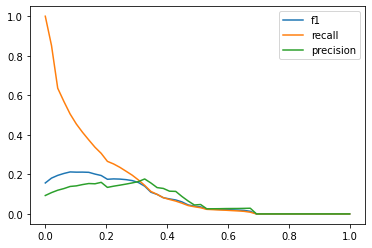

In [45]:
plt.plot(thrs, f1s, label='f1')
plt.plot(thrs, recalls, label='recall')
plt.plot(thrs, precisions, label='precision')
plt.legend()

In [46]:
!cp /content/lightning_logs/version_1/checkpoints/epoch=1-step=1112.ckpt /content/drive/MyDrive/ITMO/IndustryML/LW2/text_model_bert.ckpt

## Fusing

In [18]:
trainer = pl.Trainer()

/usr/local/lib/python3.7/dist-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
visual_predictor = FilmPreditor(VisualModel(), None, None)
visual_preds = trainer.predict(visual_predictor, predict_dl, ckpt_path='/content/drive/MyDrive/ITMO/IndustryML/LW2/cv_model_resnet101.ckpt')


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/ITMO/IndustryML/LW2/cv_model_resnet101.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/ITMO/IndustryML/LW2/cv_model_resnet101.ckpt


Predicting: 0it [00:00, ?it/s]

In [28]:
text_predict_dl = DataLoader(FilmTextDataset(X_test, y_test, is_inference=True), batch_size=64, shuffle=False)
text_predictor = FilmPreditor(TextModel(), None, None)
text_preds = trainer.predict(text_predictor, text_predict_dl, ckpt_path='/content/drive/MyDrive/ITMO/IndustryML/LW2/text_model_bert.ckpt')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/ITMO/IndustryML/LW2/text_model_bert.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/ITMO/IndustryML/LW2/text_model_bert.ckpt


Predicting: 0it [00:00, ?it/s]

In [29]:
visual_preds_f = []
text_preds_f = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    visual_preds_f.append(visual_preds[i][j].numpy())
    text_preds_f.append(text_preds[i][j].numpy())

In [30]:
y_target = np.array(y_target)
visual_preds_f = np.array(visual_preds_f)
text_preds_f = np.array(text_preds_f)
y_target.shape, visual_preds_f.shape, text_preds_f.shape

((4448, 24), (4448, 24), (4448, 24))

In [31]:
ansemle_preds = (visual_preds_f + text_preds_f) / 2

In [45]:
thrs = np.linspace(0, 1)
f1s = []
recalls = []
precisions = []
for t in thrs:
  y_pred = output_formated.copy()
  y_pred[y_pred > t] = 1
  y_pred[y_pred <= t] = 0
  metrics_dict = compute_metrics(y_target, y_pred)
  f1s.append(metrics_dict['f1_macro'])
  recalls.append(metrics_dict['recall_macro'])
  precisions.append(metrics_dict['precision_macro'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

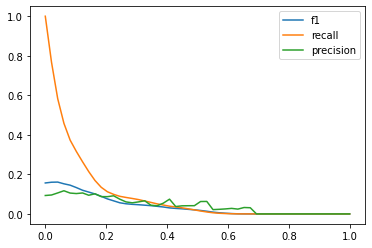

In [47]:
import matplotlib.pyplot as plt
plt.plot(thrs, f1s, label='f1')
plt.plot(thrs, recalls, label='recall')
plt.plot(thrs, precisions, label='precision')
plt.legend()

In [48]:
np.max(f1s) # Ansemble F1

0.161029461102926

In [49]:
np.max(f1s) # CV F1

0.161029461102926

In [50]:
np.max(f1s) # Text F1

0.161029461102926